In [ ]:
# Importamos librerías

import requests
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import RobustScaler
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import IsolationForest
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, roc_auc_score
from imblearn.over_sampling import SMOTENC
from sklearn.impute import SimpleImputer
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

In [ ]:
# Definimos api key, game name y tag line

gameName = "UwU OwO Arf Arf"
tagLine = "LAN"
region = "americas"
api_key = "RGAPI-9e3ec05e-1ee0-43f6-aa5c-ec63f6fdd3f0"
request_url = "https://americas.api.riotgames.com/riot/account/v1/accounts/by-riot-id/"+gameName + "/" + tagLine
api_url = request_url + '?api_key=' + api_key
print(api_url)

resp = requests.get(api_url)
player_info = resp.json()
player_info

puuid = player_info.get('puuid')
print(puuid)

https://americas.api.riotgames.com/riot/account/v1/accounts/by-riot-id/UwU OwO Arf Arf/LAN?api_key=RGAPI-9e3ec05e-1ee0-43f6-aa5c-ec63f6fdd3f0
1-Hefru-M43qtTYmibsoWi1X28bMkQZ5QjG5_xBZ09GR7ciFCLogvlWutDxs59VxZdVxRueXGOPv0g


In [ ]:
# Con la url de las partidas empezamos a recopilar los IDs

match_url = "https://americas.api.riotgames.com/lol/match/v5/matches/by-puuid/" + puuid + "/ids?type=ranked&start=0&count=20"
match_url = match_url + "&api_key=" + api_key
match_url

'https://americas.api.riotgames.com/lol/match/v5/matches/by-puuid/1-Hefru-M43qtTYmibsoWi1X28bMkQZ5QjG5_xBZ09GR7ciFCLogvlWutDxs59VxZdVxRueXGOPv0g/ids?type=ranked&start=0&count=20&api_key=RGAPI-9e3ec05e-1ee0-43f6-aa5c-ec63f6fdd3f0'

In [ ]:
# Empezamos a recolectar la información pertinente a las partidas que vamos a analizar

match_count = 100

def get_match_data(region, match_id, api_key):
    api_url = (
        f"https://{region}.api.riotgames.com/lol/match/v5/matches/{match_id}"
        f"?api_key={api_key}"
    )

    while True:
        resp = requests.get(api_url)
        if resp.status_code == 429:
            print("Rate limit exceeded. Sleeping for 10 seconds...")
            time.sleep(10)
            continue
        elif resp.status_code != 200:
            print(f"Error fetching match data for {match_id}: {resp.status_code}")
            return None
        else:
            break

    return resp.json()

def get_matches(region, puuid, count, api_key):
    api_url = (
        f"https://{region}.api.riotgames.com/lol/match/v5/matches/by-puuid/"
        f"{puuid}/ids?start=0&count={count}&api_key={api_key}"
    )

    resp = requests.get(api_url)
    if resp.status_code != 200:
        print("Error fetching matches:", resp.status_code)
        return []
    return resp.json()

matches = get_matches(region, puuid, match_count, api_key)

match_results = {}

for idx, match_id in enumerate(matches, start=1):
    print(f"Fetching data for match {idx}: {match_id}")
    match_data = get_match_data(region, match_id, api_key)

    if match_data is None:
        continue

    try:
        part_index = match_data['metadata']['participants'].index(puuid)
        participant_data = match_data['info']['participants'][part_index]
    except ValueError:
        print(f"Player not found in match {match_id}")
        continue

    total_farm = participant_data.get('totalMinionsKilled', 0) + participant_data.get('neutralMinionsKilled', 0)

    match_results[match_id] = {
        'win': participant_data['win'],
        'championName': participant_data['championName'],
        'kills': participant_data['kills'],
        'deaths': participant_data['deaths'],
        'assists': participant_data['assists'],
        'gameDuration': match_data['info'].get('gameDuration'),
        'totalMinionsKilled': participant_data.get('totalMinionsKilled'),
        'neutralMinionsKilled': participant_data.get('neutralMinionsKilled', 0),
        'totalFarm': total_farm,
        'totalDamageDealtToChampions': participant_data.get('totalDamageDealtToChampions'),
        'wardsPlaced': participant_data.get('wardsPlaced'),
        'wardsDestroyed': participant_data.get('wardsDestroyed'),
        'dragonKills': participant_data.get('dragonKills'),
        'baronKills': participant_data.get('baronKills'),
        'turretTakedowns': participant_data.get('turretTakedowns'),
        'firstBloodKill': participant_data.get('firstBloodKill'),
        'firstTowerKill': participant_data.get('firstTowerKill'),
        'firstBaron': participant_data.get('firstBaron'),
        'firstDragon': participant_data.get('firstDragon')
    }

    time.sleep(2.5)

df = pd.DataFrame.from_dict(match_results, orient='index')
print(df)

Fetching data for match 1: LA1_1608799551
Fetching data for match 2: LA1_1608612980
Fetching data for match 3: LA1_1608479952
Fetching data for match 4: LA1_1608470300
Fetching data for match 5: LA1_1608455816
Fetching data for match 6: LA1_1608449392
Fetching data for match 7: LA1_1608435684
Fetching data for match 8: LA1_1608199582
Fetching data for match 9: LA1_1607795396
Fetching data for match 10: LA1_1607748584
Fetching data for match 11: LA1_1607644852
Fetching data for match 12: LA1_1607630441
Fetching data for match 13: LA1_1607577586
Fetching data for match 14: LA1_1607567985
Fetching data for match 15: LA1_1607561867
Fetching data for match 16: LA1_1607545156
Fetching data for match 17: LA1_1607533844
Fetching data for match 18: LA1_1607496566
Fetching data for match 19: LA1_1607489831
Fetching data for match 20: LA1_1607488010
Fetching data for match 21: LA1_1607248367
Fetching data for match 22: LA1_1607042886
Fetching data for match 23: LA1_1607038334
Fetching data for ma

In [ ]:
match_data['info']

{'endOfGameResult': 'GameComplete',
 'gameCreation': 1738168467466,
 'gameDuration': 2024,
 'gameEndTimestamp': 1738170533999,
 'gameId': 1594687857,
 'gameMode': 'CLASSIC',
 'gameName': 'teambuilder-match-1594687857',
 'gameStartTimestamp': 1738168509383,
 'gameType': 'MATCHED_GAME',
 'gameVersion': '15.2.652.1536',
 'mapId': 11,
 'participants': [{'PlayerScore0': 0,
   'PlayerScore1': 0,
   'PlayerScore10': 0,
   'PlayerScore11': 0,
   'PlayerScore2': 0,
   'PlayerScore3': 0,
   'PlayerScore4': 0,
   'PlayerScore5': 0,
   'PlayerScore6': 0,
   'PlayerScore7': 0,
   'PlayerScore8': 0,
   'PlayerScore9': 0,
   'allInPings': 0,
   'assistMePings': 2,
   'assists': 9,
   'baronKills': 0,
   'basicPings': 0,
   'bountyLevel': 10,
   'challenges': {'12AssistStreakCount': 0,
    'HealFromMapSources': 1080,
    'InfernalScalePickup': 0,
    'SWARM_DefeatAatrox': 0,
    'SWARM_DefeatBriar': 0,
    'SWARM_DefeatMiniBosses': 0,
    'SWARM_EvolveWeapon': 0,
    'SWARM_Have3Passives': 0,
    'SWA

In [ ]:
# Imprimimos las columnas con los nombres de las variables a analizar
print(df.columns)

Index(['win', 'championName', 'kills', 'deaths', 'assists', 'gameDuration',
       'totalMinionsKilled', 'neutralMinionsKilled', 'totalFarm',
       'totalDamageDealtToChampions', 'wardsPlaced', 'wardsDestroyed',
       'dragonKills', 'baronKills', 'turretTakedowns', 'firstBloodKill',
       'firstTowerKill', 'firstBaron', 'firstDragon'],
      dtype='object')


In [ ]:
numeric_df = df.select_dtypes(include=[np.number])
print("Descriptive statistics for numeric columns:")
print(numeric_df.describe())

# Grouping by championName and including 'totalFarm' in the aggregation
champion_stats = df.groupby('championName').agg({
    'win': ['count', 'sum'],
    'kills': 'mean',
    'deaths': 'mean',
    'assists': 'mean',
    'gameDuration': 'mean',
    'totalMinionsKilled': 'mean',
    'neutralMinionsKilled': 'mean',
    'totalFarm': 'mean',  # Including totalFarm in aggregation
    'totalDamageDealtToChampions': 'mean',
    'wardsPlaced': 'mean',
    'wardsDestroyed': 'mean',
    'dragonKills': 'mean',
    'baronKills': 'mean',
    'turretTakedowns': 'mean',
    'firstBloodKill': 'mean',
    'firstTowerKill': 'mean',
    'firstBaron': 'mean',
    'firstDragon': 'mean'
})

# Flatten multi-level columns after aggregation
champion_stats.columns = [
    'matches', 'wins', 'avg_kills', 'avg_deaths', 'avg_assists', 'avg_gameDuration',
    'avg_minions', 'avg_neutralMinions', 'avg_totalFarm', 'avg_damage', 'avg_wardsPlaced',
    'avg_wardsDestroyed', 'avg_dragonKills', 'avg_baronKills', 'avg_turretTakedowns',
    'avg_firstBloodKill', 'avg_firstTowerKill', 'avg_firstBaron', 'avg_firstDragon'
]

# Adding win rate column
champion_stats['win_rate'] = champion_stats['wins'] / champion_stats['matches'] * 100

print("Descriptive statistics for champion stats:")
print(champion_stats.describe())

print("Champion stats aggregated by championName:")
print(champion_stats)


Descriptive statistics for numeric columns:
            kills      deaths     assists  gameDuration  totalMinionsKilled  \
count  100.000000  100.000000  100.000000    100.000000          100.000000   
mean     9.150000    5.580000    7.960000   1713.450000           35.450000   
std      5.938022    3.219825    5.122578    520.941075           39.943742   
min      0.000000    0.000000    0.000000    105.000000            0.000000   
25%      5.000000    3.000000    4.000000   1465.500000           12.750000   
50%      8.000000    6.000000    7.000000   1747.500000           23.500000   
75%     13.000000    8.000000   11.000000   2020.250000           42.000000   
max     31.000000   14.000000   24.000000   3239.000000          233.000000   

       neutralMinionsKilled   totalFarm  totalDamageDealtToChampions  \
count            100.000000  100.000000                   100.000000   
mean             125.460000  160.910000                 24662.460000   
std               79.539003 

In [ ]:
# Matriz de correlación
correlation_matrix = df.corr(numeric_only=True)
print(correlation_matrix)

                                  win     kills    deaths   assists  \
win                          1.000000  0.220598 -0.467430  0.177368   
kills                        0.220598  1.000000  0.313976  0.478385   
deaths                      -0.467430  0.313976  1.000000  0.436846   
assists                      0.177368  0.478385  0.436846  1.000000   
gameDuration                -0.058905  0.358498  0.496372  0.337498   
totalMinionsKilled           0.103423  0.263750  0.165159  0.142707   
neutralMinionsKilled         0.064716  0.073401  0.006126 -0.006797   
totalFarm                    0.117665  0.207637  0.089839  0.065431   
totalDamageDealtToChampions  0.172707  0.775548  0.506324  0.616200   
wardsPlaced                  0.032416  0.067168  0.060227 -0.087597   
dragonKills                  0.408320  0.160097 -0.256106  0.071366   
baronKills                   0.148977  0.033657 -0.037062  0.116253   
turretTakedowns              0.447810  0.309205 -0.162226  0.274432   
firstB

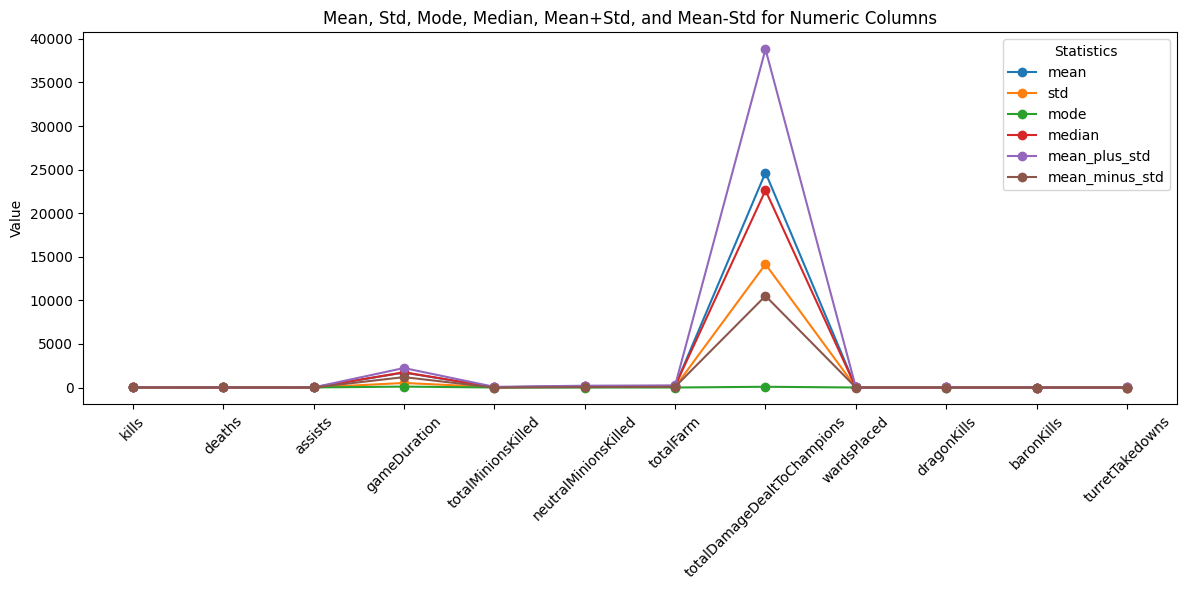

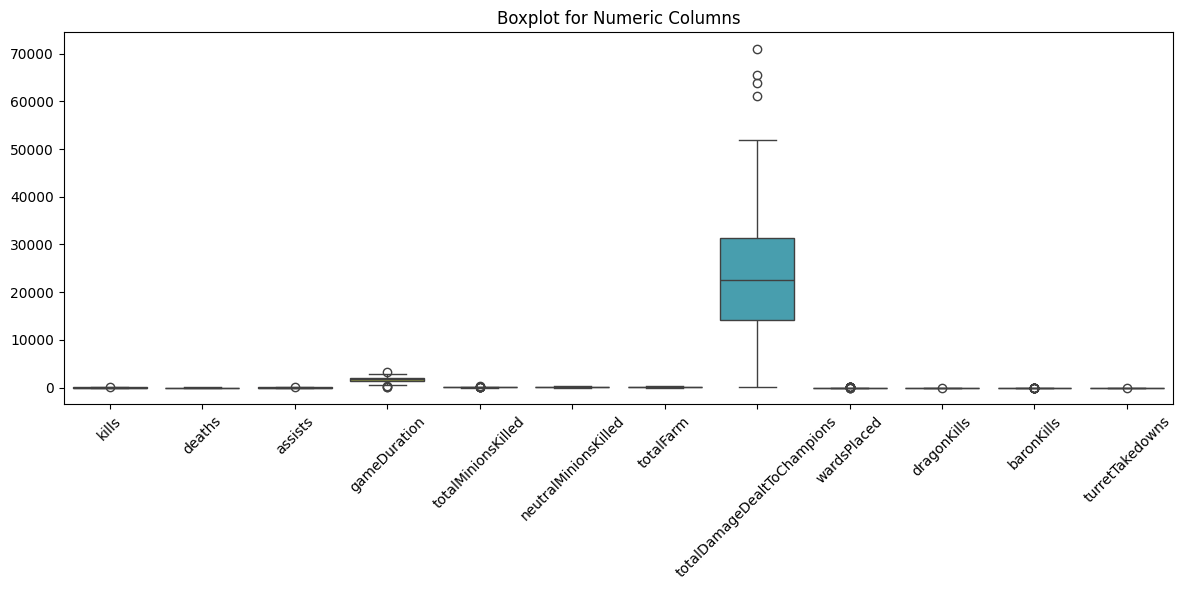

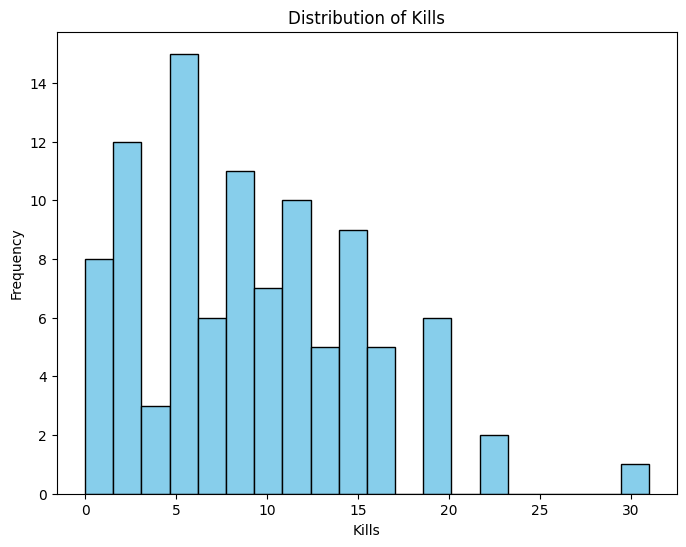

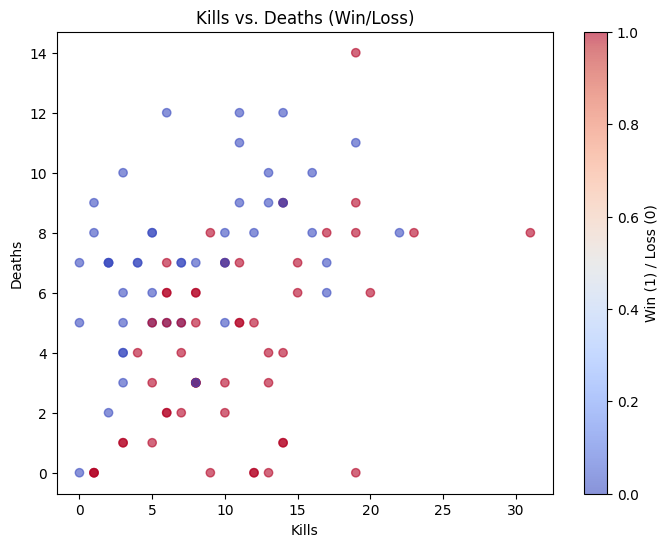

<ipython-input-11-7a4b04c208d7>:58: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='championName', y='win_rate', data=champ_stats_reset, palette='viridis')


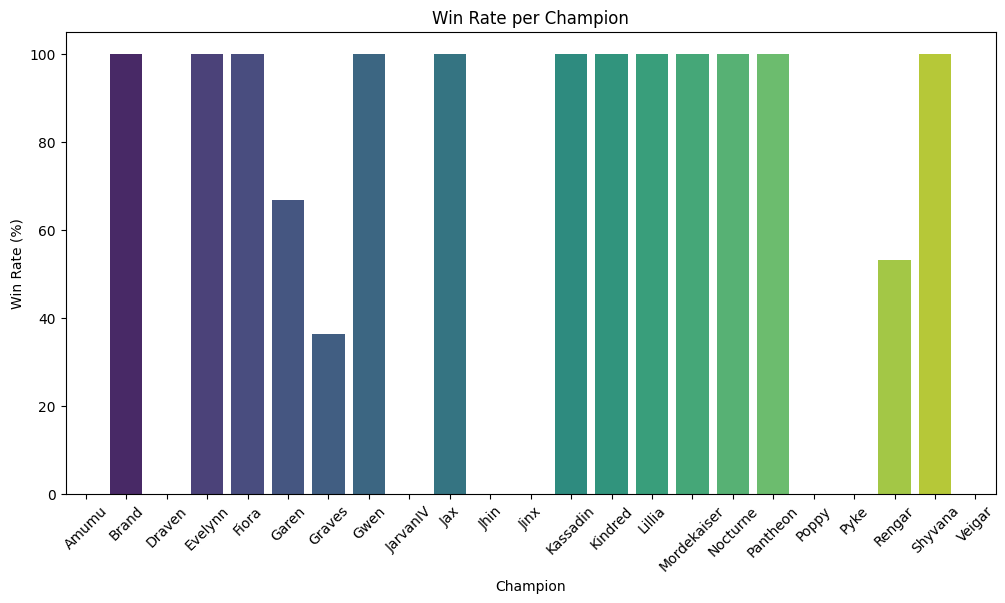

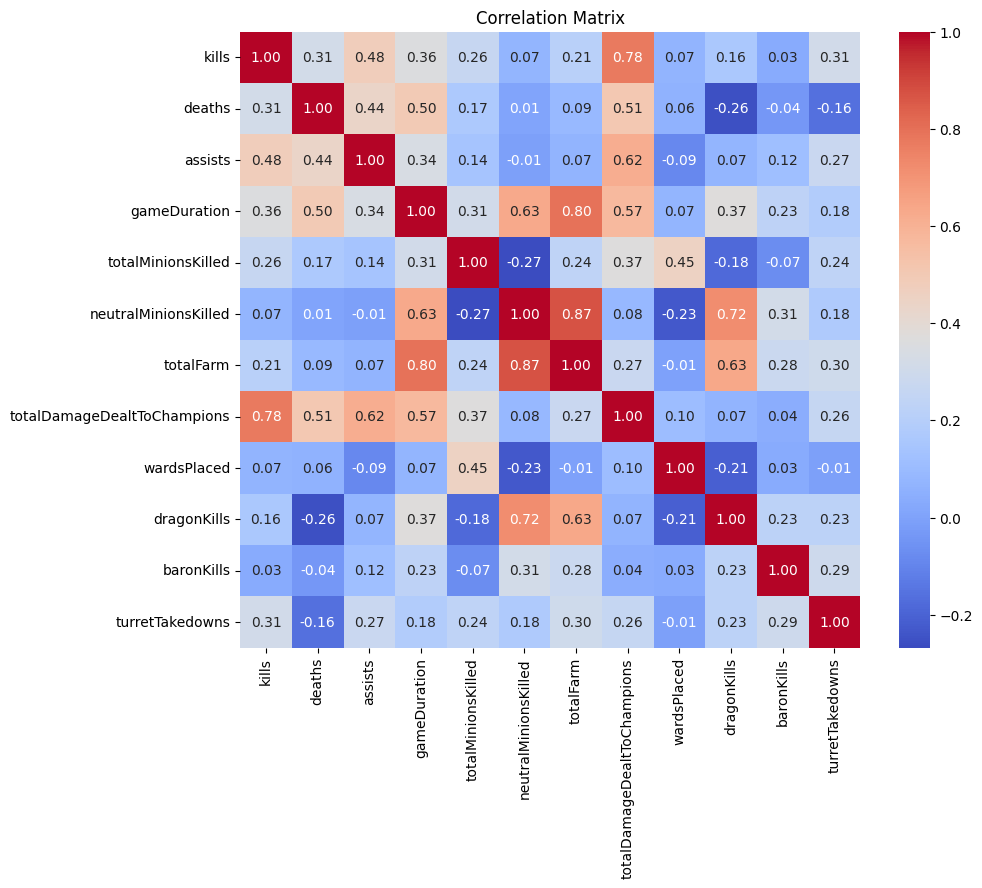

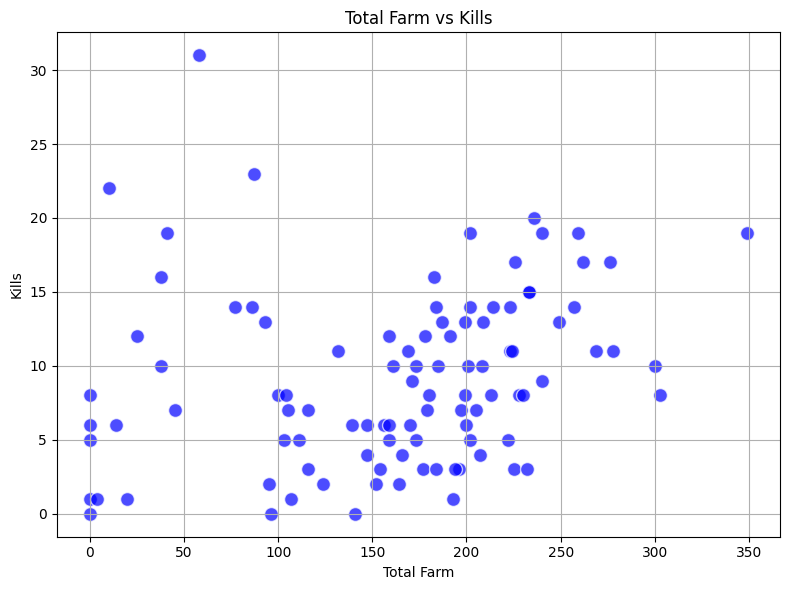

In [ ]:
# Gráficamos los datos

numeric_stats = numeric_df.describe().T
numeric_stats['std'] = numeric_df.std()
numeric_stats['mode'] = numeric_df.mode().iloc[0]
numeric_stats['median'] = numeric_df.median()

numeric_stats['mean_plus_std'] = numeric_stats['mean'] + numeric_stats['std']
numeric_stats['mean_minus_std'] = numeric_stats['mean'] - numeric_stats['std']

stats = ['mean', 'std', 'mode', 'median', 'mean_plus_std', 'mean_minus_std']
stats_values = []

for stat in stats:
    stats_values.append(numeric_stats[stat].values)

plt.figure(figsize=(12, 6))
x_labels = numeric_stats.index
for i, stat in enumerate(stats):
    plt.plot(x_labels, stats_values[i], label=stat, marker='o')

plt.title('Mean, Std, Mode, Median, Mean+Std, and Mean-Std for Numeric Columns')
plt.ylabel('Value')
plt.xticks(rotation=45)
plt.legend(title='Statistics')
plt.tight_layout()
plt.show()

# Boxplot to visualize the distribution of numeric columns
plt.figure(figsize=(12, 6))
sns.boxplot(data=numeric_df)
plt.title('Boxplot for Numeric Columns')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

if 'kills' in df.columns:
    plt.figure(figsize=(8, 6))
    plt.hist(df['kills'], bins=20, color='skyblue', edgecolor='black')
    plt.title('Distribution of Kills')
    plt.xlabel('Kills')
    plt.ylabel('Frequency')
    plt.show()

plt.figure(figsize=(8, 6))
if 'kills' in df.columns and 'deaths' in df.columns and 'win' in df.columns:
    scatter = plt.scatter(df['kills'], df['deaths'], alpha=0.6,
                          c=df['win'].astype(int), cmap='coolwarm')
    plt.title('Kills vs. Deaths (Win/Loss)')
    plt.xlabel('Kills')
    plt.ylabel('Deaths')
    plt.colorbar(scatter, label='Win (1) / Loss (0)')
    plt.show()

champ_stats_reset = champion_stats.reset_index()

plt.figure(figsize=(12, 6))
sns.barplot(x='championName', y='win_rate', data=champ_stats_reset, palette='viridis')
plt.title('Win Rate per Champion')
plt.xlabel('Champion')
plt.ylabel('Win Rate (%)')
plt.xticks(rotation=45)
plt.show()

plt.figure(figsize=(10, 8))
corr_matrix = numeric_df.corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

plt.figure(figsize=(8, 6))
plt.scatter(df['totalFarm'], df['kills'], alpha=0.7, c='b', edgecolors='w', s=100)
plt.title("Total Farm vs Kills")
plt.xlabel("Total Farm")
plt.ylabel("Kills")
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
from lightgbm import LGBMClassifier

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report

In [ ]:
df_merged = pd.merge(df, champion_stats, on='championName', how='left')

# New features for League of Legends dataset
df_merged['KDA'] = (df_merged['kills'] + df_merged['assists']) / (df_merged['deaths'].replace(0, 1e-9) + 1e-9)
df_merged['minionsPerMinute'] = df_merged['totalMinionsKilled'] / (df_merged['gameDuration'] / 60)
df_merged['damagePerMinute'] = df_merged['totalDamageDealtToChampions'] / (df_merged['gameDuration'] / 60)
df_merged['firstObjectiveCount'] = df_merged[['firstBloodKill', 'firstTowerKill', 'firstBaron', 'firstDragon']].sum(axis=1)
df_merged['wardScore'] = df_merged['wardsPlaced'] + 2 * df_merged['wardsDestroyed']
df_merged['highDeaths'] = (df_merged['deaths'] > 10).astype(int)
df_merged['gamePhase'] = pd.cut(df_merged['gameDuration'],
                                bins=[0, 1500, 2500, 9999],  # 0-25m, 25-41m, 41m+
                                labels=['Early', 'Mid', 'Late'])
df_merged['killsXdamage'] = df_merged['kills'] * df_merged['totalDamageDealtToChampions']
df_merged['deathsXassists'] = df_merged['deaths'] * df_merged['assists']

In [ ]:
numeric_cols = df_merged.select_dtypes(include=["number"]).columns.tolist()
for col in numeric_cols:
    if df_merged[col].isnull().sum() > 0:
        df_merged[col].fillna(df_merged[col].median(), inplace=True)

In [ ]:
categorical_cols = df_merged.select_dtypes(include=["object"]).columns.tolist()
for col in categorical_cols:
    if df_merged[col].isnull().sum() > 0:
        mode_val = df_merged[col].mode()
        if not mode_val.empty:
            df_merged[col].fillna(mode_val.iloc[0], inplace=True)
        else:
            # Optionally, fill with a default value if no mode is found
            df_merged[col].fillna("Unknown", inplace=True)

<ipython-input-44-3d22dc72b7c1>:9: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_merged[col].fillna("Unknown", inplace=True)


In [ ]:
def outlier_thresholds(dataframe, variable, low_quantile=0.05, up_quantile=0.95):
    quantile_one = dataframe[variable].quantile(low_quantile)
    quantile_three = dataframe[variable].quantile(up_quantile)
    interquantile_range = quantile_three - quantile_one
    up_limit = quantile_three + 1.5 * interquantile_range
    low_limit = quantile_one - 1.5 * interquantile_range
    return low_limit, up_limit

In [ ]:
def has_outliers(dataframe, numeric_columns, plot=False):
    for col in numeric_columns:
        low_limit, up_limit = outlier_thresholds(dataframe, col)
        outliers = dataframe[(dataframe[col] > up_limit) | (dataframe[col] < low_limit)]
        if not outliers.empty:
            print(f"{col}: {outliers.shape[0]} outliers")
            if plot:
                sns.boxplot(x=dataframe[col])
                plt.title(f"Boxplot for {col}")
                plt.show()

In [ ]:
for col in numeric_cols:
    has_outliers(df_merged, [col], plot=False)

avg_kills: 2 outliers
avg_damage: 1 outliers
avg_firstBloodKill: 3 outliers
avg_firstTowerKill: 2 outliers
KDA: 5 outliers


In [ ]:
X = df_merged.drop([
    'win',               # target variable
    'championName',      # identifier
    'gameDuration',      # used for feature engineering
    'win_rate',          # meta-information
    'wins',
    'totalFarm',
    'damagePerMinute',   # engineered features can be dropped if desired
    'firstObjectiveCount',
    'wardScore',
    'firstDragon',
    'firstBaron',
    'firstTowerKill',
    'firstBloodKill'
], axis=1)
y = df_merged['win']

In [ ]:
scaler = StandardScaler()
numeric_features = X.select_dtypes(include=["number"]).columns.tolist()
X[numeric_features] = scaler.fit_transform(X[numeric_features])

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
from lightgbm import LGBMClassifier

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report

# Merge dataframes (df and champion_stats must be defined earlier)
df_merged = pd.merge(df, champion_stats, on='championName', how='left')

# Feature engineering for League of Legends dataset
df_merged['KDA'] = (df_merged['kills'] + df_merged['assists']) / (df_merged['deaths'].replace(0, 1e-9) + 1e-9)
df_merged['minionsPerMinute'] = df_merged['totalMinionsKilled'] / (df_merged['gameDuration'] / 60)
df_merged['damagePerMinute'] = df_merged['totalDamageDealtToChampions'] / (df_merged['gameDuration'] / 60)
df_merged['firstObjectiveCount'] = df_merged[['firstBloodKill', 'firstTowerKill', 'firstBaron', 'firstDragon']].sum(axis=1)
df_merged['wardScore'] = df_merged['wardsPlaced'] + 2 * df_merged['wardsDestroyed']
df_merged['highDeaths'] = (df_merged['deaths'] > 10).astype(int)
df_merged['gamePhase'] = pd.cut(df_merged['gameDuration'],
                                bins=[0, 1500, 2500, 9999],  # 0-25m, 25-41m, 41m+
                                labels=['Early', 'Mid', 'Late'])
df_merged['killsXdamage'] = df_merged['kills'] * df_merged['totalDamageDealtToChampions']
df_merged['deathsXassists'] = df_merged['deaths'] * df_merged['assists']

# Fill missing values for numeric features with the median
numeric_cols = df_merged.select_dtypes(include=["number"]).columns.tolist()
for col in numeric_cols:
    if df_merged[col].isnull().sum() > 0:
        df_merged[col].fillna(df_merged[col].median(), inplace=True)

# Fill missing values for categorical features with the mode or 'Unknown'
categorical_cols = df_merged.select_dtypes(include=["object"]).columns.tolist()
for col in categorical_cols:
    if df_merged[col].isnull().sum() > 0:
        mode_val = df_merged[col].mode()
        if not mode_val.empty:
            df_merged[col].fillna(mode_val.iloc[0], inplace=True)
        else:
            df_merged[col].fillna("Unknown", inplace=True)

# Outlier helper functions
def outlier_thresholds(dataframe, variable, low_quantile=0.05, up_quantile=0.95):
    quantile_one = dataframe[variable].quantile(low_quantile)
    quantile_three = dataframe[variable].quantile(up_quantile)
    interquantile_range = quantile_three - quantile_one
    up_limit = quantile_three + 1.5 * interquantile_range
    low_limit = quantile_one - 1.5 * interquantile_range
    return low_limit, up_limit

def has_outliers(dataframe, numeric_columns, plot=False):
    for col in numeric_columns:
        low_limit, up_limit = outlier_thresholds(dataframe, col)
        outliers = dataframe[(dataframe[col] > up_limit) | (dataframe[col] < low_limit)]
        if not outliers.empty:
            print(f"{col}: {outliers.shape[0]} outliers")
            if plot:
                sns.boxplot(x=dataframe[col])
                plt.title(f"Boxplot for {col}")
                plt.show()

for col in numeric_cols:
    has_outliers(df_merged, [col], plot=False)

# Define feature matrix X and target variable y
X = df_merged.drop([
    'win',               # target variable
    'championName',      # identifier
    'gameDuration',      # used for feature engineering
    'win_rate',          # meta-information
    'wins',
    'totalFarm',
    'damagePerMinute',   # engineered features can be dropped if desired
    'firstObjectiveCount',
    'wardScore',
    'firstDragon',
    'firstBaron',
    'firstTowerKill',
    'firstBloodKill'
], axis=1)

y = df_merged['win']

# Convert categorical features to numeric using one-hot encoding
X = pd.get_dummies(X, drop_first=True)

# Scale numeric features
scaler = StandardScaler()
numeric_features = X.select_dtypes(include=["number"]).columns.tolist()
X[numeric_features] = scaler.fit_transform(X[numeric_features])

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=12345)

# Define models
models = [
    ('LR', LogisticRegression(random_state=123456)),
    ('KNN', KNeighborsClassifier()),
    ('CART', DecisionTreeClassifier(random_state=123456)),
    ('SVR', SVC(gamma='auto', random_state=123456)),
    ('GB', GradientBoostingClassifier(random_state=12345)),
    ("LightGBM", LGBMClassifier(random_state=123456))
]

# Define parameter grids for models to tune
param_grids = {
    'LR': {'C': [0.001, 0.01, 0.1, 1, 10, 100]},
    'KNN': {'n_neighbors': np.arange(1, 50)},
    'CART': {'max_depth': list(range(1, 20)), 'min_samples_split': [2, 5, 10]},
    'SVR': {'C': [0.1, 1, 10, 100], 'kernel': ['linear', 'rbf']},
    'GB': {'n_estimators': [50, 100, 200], 'learning_rate': [0.01, 0.1, 1]}
}

results = []
model_names = []
train_scores = []
test_scores = []

for name, model in models:
    print(f"--- Model: {name} ---")

    # Perform grid search if parameter grid is defined for the model
    if name in param_grids:
        grid = GridSearchCV(model, param_grids[name], cv=5, return_train_score=True)
        grid.fit(X_train, y_train)
        print("Best Validation Score:", grid.best_score_)
        print("Best Parameters:", grid.best_params_)
        best_model = grid.best_estimator_
        # Use the best training score if available
        if 'mean_train_score' in grid.cv_results_:
            train_scores.append(max(grid.cv_results_['mean_train_score']))
        else:
            train_scores.append(best_model.score(X_train, y_train))
    else:
        best_model = model
        best_model.fit(X_train, y_train)
        train_scores.append(best_model.score(X_train, y_train))

    # Evaluate the model on the test set
    y_pred = best_model.predict(X_test)
    test_accuracy = accuracy_score(y_test, y_pred)
    test_scores.append(test_accuracy)

    print(classification_report(y_test, y_pred))
    print("-" * 50)

<ipython-input-68-f44df4c440da>:47: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_merged[col].fillna("Unknown", inplace=True)


avg_kills: 2 outliers
avg_damage: 1 outliers
avg_firstBloodKill: 3 outliers
avg_firstTowerKill: 2 outliers
KDA: 5 outliers
--- Model: LR ---
Best Validation Score: 0.9125
Best Parameters: {'C': 10}
              precision    recall  f1-score   support

       False       0.89      0.67      0.76        12
        True       0.64      0.88      0.74         8

    accuracy                           0.75        20
   macro avg       0.76      0.77      0.75        20
weighted avg       0.79      0.75      0.75        20

--------------------------------------------------
--- Model: KNN ---
Best Validation Score: 0.8125
Best Parameters: {'n_neighbors': np.int64(5)}
              precision    recall  f1-score   support

       False       0.82      0.75      0.78        12
        True       0.67      0.75      0.71         8

    accuracy                           0.75        20
   macro avg       0.74      0.75      0.74        20
weighted avg       0.76      0.75      0.75        20

--

In [ ]:
# Print the maximum training and testing scores with model indices
if train_scores:
    max_train_score = max(train_scores)
    train_indices = [i + 1 for i, v in enumerate(train_scores) if v == max_train_score]
    print('Max train score: {:.2f}% in model(s) k = {}'.format(max_train_score * 100, train_indices))
else:
    print("No training scores available.")

max_test_score = max(test_scores)
test_indices = [i + 1 for i, v in enumerate(test_scores) if v == max_test_score]
print('Max test score: {:.2f}% in model(s) k = {}'.format(max_test_score * 100, test_indices))

Max train score: 100.00% in model(s) k = [1, 2, 3, 4, 5, 6]
Max test score: 75.00% in model(s) k = [1, 2, 4]
